# Практическое задание №2 

## Общая терминология по используемым данным

Предоставляемые данные для разработки моделей и алгоритмов трекинга мяча в теннисе представляют собор набор игр (game), состоящих из нескольких клипов (clip), каждый из которых состоит из набора кадров (frame). Обратите внимание на структуру организации файлов внутри предоставляемого датасета для полного понимания.

Большинство алгоритмов трекинга объектов работают с несколькими последовательными кадрами, и в данном задании также подразумевается использование этого приема. Последовательность нескольких кадров будем именовать стопкой (stack), размер стопки (stack_s) является гиперпараметром разрабатываемого алгоритма.

# Заготовка решения

## Загрузка датасета
Для работы с данными в ноутбуке kaggle необходимо подключить датасет. File -> Add or upload data, далее в поиске написать tennis-tracking-assignment и выбрать датасет. Если поиск не работает, то можно добавить датасет по url: https://www.kaggle.com/xubiker/tennistrackingassignment. После загрузки данные датасета будут примонтированы в ../input/tennistrackingassignment.

## Установка и импорт зависимостей

Установка необходимых пакетов (не забудьте "включить интернет" в настройках ноутбука kaggle):

In [1]:
!pip install moviepy --upgrade
!pip install gdown

<font color=red>
После установки пакетов для корректной работы надо обязательно перезагрузить ядро. Run -> Restart and clear cell outputs. Без сего действа будет ошибка при попытке обращения к библиотеке moviepy при сохранении визуализации в виде видео. Может когда-то авторы библиотеки это починят...
</font>

Импорт необходимых зависимостей:

In [26]:
from pathlib import Path
from typing import List, Tuple, Sequence

import numpy as np
from numpy import unravel_index
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm, notebook

from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

import math
from scipy.ndimage import gaussian_filter

import cv2 as cv
import gc
import time
import random
import csv
import IPython.display
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision.transforms import v2
import matplotlib as mpl
import matplotlib.pyplot as plt
import gdown

## Набор функций для загрузки данных из датасета

Функция load_clip_data загружает выбранный клип из выбранной игры и возвращает его в виде numpy массива [n_frames, height, width, 3] типа uint8. Для ускорения загрузки используется кэширование - однажды загруженные клипы хранятся на диске в виде npz архивов, при последующем обращении к таким клипам происходит загрузка npz архива.

<font color="red">
Также добавлена возможность чтения клипа в половинном разрешении 640x360, вместо оригинального 1280x720 для упрощения и ускорения разрабатываемых алгоритмов.
</font>

Функция load_clip_labels загружает референсные координаты мяча в клипе в виде numpy массива [n_frames, 4], где в каждой строке массива содержатся значения [code, x, y, q]. x, y соответствуют координате центра мяча на кадре, q не используется в данном задании, code описывает статус мяча:
* code = 0 - мяча в кадре нет
* code = 1 - мяч присутствует в кадре и легко идентифицируем
* code = 2 - мяч присутствует в кадре, но сложно идентифицируем
* code = 3 - мяч присутствует в кадре, но заслонен другими объектами.

При загрузке в половинном разрешении координаты x, y делятся на 2.

Функция load_clip загружает выбранный клип и соответствующий массив координат и возвращает их в виде пары.

In [4]:
def get_num_clips(path: Path, game: int) -> int:
    return len(list((path / f'game{game}/').iterdir()))


def get_game_clip_pairs(path: Path, games: List[int]) -> List[Tuple[int, int]]:
    return [(game, c)  for game in games for c in range(1, get_num_clips(path, game) + 1)]


def load_clip_data(path: Path, game: int, clip: int, downscale: bool, quiet=False) -> np.ndarray:
    if not quiet:
        suffix = 'downscaled' if downscale else ''
        print(f'loading clip data (game {game}, clip {clip}) {suffix}')
    cache_path = path / 'cache'
    cache_path.mkdir(exist_ok=True)
    resize_code = '_ds2' if downscale else ''
    cached_data_name = f'{game}_{clip}{resize_code}.npz'
    if (cache_path / cached_data_name).exists():
        clip_data = np.load(cache_path / cached_data_name)['clip_data']
    else:
        clip_path = path / f'game{game}/clip{clip}'
        n_imgs = len(list(clip_path.iterdir())) - 1
        imgs = [None] * n_imgs
        for i in notebook.tqdm(range(n_imgs)):
            img = Image.open(clip_path / f'{i:04d}.jpg')
            if downscale:
                img = img.resize((img.width // 2, img.height // 2),)
            imgs[i] = np.array(img, dtype=np.uint8)
        clip_data = np.stack(imgs)
        cache_path.mkdir(exist_ok=True, parents=True)
        np.savez_compressed(cache_path / cached_data_name, clip_data=clip_data)
    return clip_data


def load_clip_labels(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    if not quiet:
        print(f'loading clip labels (game {game}, clip {clip})')
    clip_path = path / f'game{game}/clip{clip}'
    labels = []
    with open(clip_path / 'labels.csv') as csvfile:
        lines = list(csv.reader(csvfile))
        for line in lines[1:]:
            values = np.array([-1 if i == '' else int(i) for i in line[1:]])
            if downscale:
                values[1] //= 2
                values[2] //= 2
            labels.append(values)
    return np.stack(labels)


def load_clip(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    data = load_clip_data(path, game, clip, downscale, quiet)
    labels = load_clip_labels(path, game, clip, downscale, quiet)
    return data, labels


## Набор дополнительных функций

Еще несколько функций, немного облегчающих выполнение задания:

* prepare_expariment создает новую директорию в out_path для хранения результатов текущего эксперимента. Нумерация выполняется автоматически, функция возвращает путь к созданной директории эксперимента;
* ball_gauss_template - создает "шаблон" мяча, может быть использована в алгоритмах поиска мяча на изображении по корреляции;
* create_masks - принимает набор кадров и набор координат мяча, и генерирует набор масок, в которых помещает шаблон мяча на заданные координаты. Может быть использована при обучении нейронной сети семантической сегментации;

In [6]:
def prepare_experiment(out_path: Path) -> Path:
    out_path.mkdir(parents=True, exist_ok=True)
    dirs = [d for d in out_path.iterdir() if d.is_dir() and d.name.startswith('exp_')]
    experiment_id = max(int(d.name.split('_')[1]) for d in dirs) + 1 if dirs else 1
    exp_path = out_path / f'exp_{experiment_id}'
    exp_path.mkdir()
    return exp_path


def ball_gauss_template(rad, sigma):
    x, y = np.meshgrid(np.linspace(-rad, rad, 2 * rad + 1), np.linspace(-rad, rad, 2 * rad + 1)) 
    dst = np.sqrt(x * x + y * y) 
    gauss = np.exp(-(dst ** 2 / (2.0 * sigma ** 2)))     
    return gauss


def create_masks(data: np.ndarray, labels: np.ndarray, resize):
    rad = 64 #25
    sigma = 10
    if resize:
        rad //= 2
    ball = ball_gauss_template(rad, sigma)
    n_frames = data.shape[0]
    sh = rad
    masks = []
    for i in range(n_frames):
        label = labels[i, ...] 
        frame = data[i, ...]
        if 0 < label[0] < 3:
            x, y = label[1:3]
            mask = np.zeros((frame.shape[0] + 2 * rad + 2 * sh, frame.shape[1] + 2 * rad + 2 * sh), np.float32)
            mask[y + sh : y + sh + 2 * rad + 1, x + sh : x + sh + 2 * rad + 1] = ball
            mask = mask[rad + sh : -rad - sh, rad + sh : -rad - sh]
            masks.append(mask)
        else:
            masks.append(np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32))
    return np.stack(masks)


## Набор функций, предназначенных для визуализации результатов

Функция visualize_prediction принимает набор кадров, набор координат детекции мяча (можно подавать как референсные значения, так и предсказанные) и создает видеоклип, в котором отрисовывается положение мяча, его трек, номер кадра и метрика качества трекинга (если она была передана в функцию). Видеоклип сохраняется в виде mp4 файла. Кроме того данная функция создает текстовый файл, в который записывает координаты детекции мяча и значения метрики качества трекинга.

Функция visualize_prob принимает набор кадров и набор предсказанных карт вероятности и создает клип с наложением предсказанных карт вероятности на исходные карты. Области "подсвечиваются" желтым, клип сохраняется в виде mp4 видеофайла. Данная функция может быть полезна при наличии в алгоритме трекинга сети, осуществляющей семантическую сегментацию.

In [7]:
def _add_frame_number(frame: np.ndarray, number: int) -> np.ndarray:
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), f'frame {number}', font=fnt, fill=(255, 0, 255))
    return np.array(img)


def _vis_clip(data: np.ndarray, lbls: np.ndarray, metrics: List[float] = None, ball_rad=5, color=(255, 0, 0), track_length=10):
    print('perfoming clip visualization')
    n_frames = data.shape[0]
    frames_res = []
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    for i in range(n_frames):
        img = Image.fromarray(data[i, ...])
        draw = ImageDraw.Draw(img)
        txt = f'frame {i}'
        if metrics is not None:
            txt += f', SiBaTrAcc: {metrics[i]:.3f}'
        draw.text((10, 10), txt, font=fnt, fill=(255, 0, 255))
        label = lbls[i]
        if label[0] != 0: # the ball is clearly visible
            px, py = label[1], label[2]
            draw.ellipse((px - ball_rad, py - ball_rad, px + ball_rad, py + ball_rad), outline=color, width=2)
            for q in range(track_length):
                if lbls[i-q-1][0] == 0:
                    break
                if i - q > 0:
                    draw.line((lbls[i - q - 1][1], lbls[i - q - 1][2], lbls[i - q][1], lbls[i - q][2]), fill=color)                
        frames_res.append(np.array(img))
    return frames_res


def _save_clip(frames: Sequence[np.ndarray], path: Path, fps):
    assert path.suffix in ('.mp4', '.gif')
    clip = ImageSequenceClip(frames, fps=fps)
    if path.suffix == '.mp4':
        clip.write_videofile(str(path), fps=fps, logger=None)
    else:
        clip.write_gif(str(path), fps=fps, logger=None)


def _to_yellow_heatmap(frame: np.ndarray, pred_frame: np.ndarray, alpha=0.4):
    img = Image.fromarray((frame * alpha).astype(np.uint8))
    maskR = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskG = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskB = np.zeros_like(maskG, dtype=np.uint8)
    mask = np.stack([maskR, maskG, maskB], axis=-1)
    return img + mask


def _vis_pred_heatmap(data_full: np.ndarray, pred_prob: np.ndarray, display_frame_number):
    n_frames = data_full.shape[0]
    v_frames = []
    for i in range(n_frames):
        frame = data_full[i, ...]
        pred = pred_prob[i, ...]
        hm = _to_yellow_heatmap(frame, pred)
        if display_frame_number:
            hm = _add_frame_number(hm, i)
        v_frames.append(hm)
    return v_frames


def visualize_prediction(data_full: np.ndarray, labels_pr: np.ndarray, save_path: Path, name: str, metrics=None, fps=15):
    with open(save_path / f'{name}.txt', mode='w') as f:
        if metrics is not None:
            f.write(f'SiBaTrAcc: {metrics[-1]} \n')
        for i in range(labels_pr.shape[0]):
            f.write(f'frame {i}: {labels_pr[i, 0]}, {labels_pr[i, 1]}, {labels_pr[i, 2]} \n')

    v = _vis_clip(data_full, labels_pr, metrics)
    _save_clip(v, save_path / f'{name}.mp4', fps=fps)


def visualize_prob(data: np.ndarray, pred_prob: np.ndarray, save_path: Path, name: str, frame_number=True, fps=15):
    v_pred = _vis_pred_heatmap(data, pred_prob, frame_number)
    _save_clip(v_pred, save_path / f'{name}_prob.mp4', fps=fps)


## Класс DataGenerator 

Класс, отвечающий за генерацию данных для обучения модели. Принимает на вход путь к директории с играми, индексы игр, используемые для генерации данных, и размер стопки. Хранит в себе автоматически обновляемый пул с клипами игр.

В пуле содержится pool_s клипов. DataGenerator позволяет генерировать батч из стопок (размера stack_s) последовательных кадров. Выбор клипа для извлечения данных взвешенно-случайный: чем больше длина клипа по сравнению с другими клипами в пуле, тем вероятнее, что именно из него будет сгенерирована стопка кадров. Выбор стопки кадров внтури выбранного клипа полностью случаен. Кадры внутри стопки конкатенируются по последнему измерению (каналам).

После генерирования количества кадров равного общему количеству кадров, хранимых в пуле, происходит автоматическое обновление пула: из пула извлекаются pool_update_s случайных клипов, после чего в пул загружается pool_update_s случайных клипов, не присутствующих в пуле. В случае, если размер пула pool_s больше или равен суммарному количеству клипов в играх, переданных в конструктор, все клипы сразу загружаются в пул, и автообновление не производится.

Использование подобного пула позволяет работать с практически произвольным количеством клипов, без необходимости загружать их всех в оперативную память.

Для вашего удобства функция извлечения стопки кадров из пула помимо самой стопки также создает и возвращает набор сгенерированных масок с мячом исходя из референсных координат мяча в клипе.

Функция random_g принимает гиперпараметр размера стопки кадров и предоставляет генератор, возвращающий стопки кадров и соответствующие им маски. Данный генератор может быть использован при реализации решения на tensorflow. Обновление пула происходит автоматически, об этом беспокоиться не нужно.

In [8]:
class DataGenerator:

    def __init__(self, path: Path, games: List[int], stack_s, downscale, pool_s=30, pool_update_s=10, pool_autoupdate=True, quiet=False) -> None:
        self.path = path
        self.stack_s = stack_s
        self.downscale = downscale
        self.pool_size = pool_s
        self.pool_update_size = pool_update_s
        self.pool_autoupdate = pool_autoupdate
        self.quiet = quiet
        self.data = []
        self.masks = []

        self.frames_in_pool = 0
        self.produced_frames = 0
        self.game_clip_pairs = get_game_clip_pairs(path, list(set(games)))
        self.game_clip_pairs_loaded = []
        self.game_clip_pairs_not_loaded = list.copy(self.game_clip_pairs) 
        self.pool = {}

        self._first_load()

    def _first_load(self):
        # --- if all clips can be placed into pool at once, there is no need to refresh pool at all ---
        if len(self.game_clip_pairs) <= self.pool_size:
            for gcp in self.game_clip_pairs:
                self._load(gcp)
            self.game_clip_pairs_loaded = list.copy(self.game_clip_pairs)
            self.game_clip_pairs_not_loaded.clear()
            self.pool_autoupdate = False
        else:
            self._load_to_pool(self.pool_size)        
        self._update_clip_weights()

    def _load(self, game_clip_pair):
        game, clip = game_clip_pair
        data, labels = load_clip(self.path, game, clip, self.downscale, quiet=self.quiet)
        masks = create_masks(data, labels, self.downscale)
        weight = data.shape[0] if data.shape[0] >= self.stack_s else 0
        self.pool[game_clip_pair] = (data, labels, masks, weight)
        self.frames_in_pool += data.shape[0] - self.stack_s + 1
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _remove(self, game_clip_pair):
        value = self.pool.pop(game_clip_pair)
        self.frames_in_pool -= value[0].shape[0] - self.stack_s + 1
        del value
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _update_clip_weights(self):
        weights = [self.pool[pair][-1] for pair in self.game_clip_pairs_loaded]
        tw = sum(weights)
        self.clip_weights = [w / tw for w in weights]
        # print(f'clip weights: {self.clip_weights}')

    def _remove_from_pool(self, n):
        # --- remove n random clips from pool ---
        if len(self.game_clip_pairs_loaded) >= n:
            remove_pairs = random.sample(self.game_clip_pairs_loaded, n)
            for pair in remove_pairs:
                self._remove(pair)
                self.game_clip_pairs_loaded.remove(pair)
                self.game_clip_pairs_not_loaded.append(pair)
            gc.collect()

    def _load_to_pool(self, n):
        # --- add n random clips to pool ---
        gc.collect()
        add_pairs = random.sample(self.game_clip_pairs_not_loaded, n)
        for pair in add_pairs:
            self._load(pair)
            self.game_clip_pairs_not_loaded.remove(pair)
            self.game_clip_pairs_loaded.append(pair)

    def update_pool(self):
        self._remove_from_pool(self.pool_update_size)
        self._load_to_pool(self.pool_update_size)
        self._update_clip_weights()

    def get_random_stack(self):
        pair_idx = np.random.choice(len(self.game_clip_pairs_loaded), 1, p=self.clip_weights)[0]
        game_clip_pair = self.game_clip_pairs_loaded[pair_idx]
        d, _, m, _ = self.pool[game_clip_pair]
        start = np.random.choice(d.shape[0] - self.stack_s, 1)[0]
        frames_stack = d[start : start + self.stack_s, ...]
        frames_stack = np.squeeze(np.split(frames_stack, indices_or_sections=self.stack_s, axis=0))
        frames_stack = np.concatenate(frames_stack, axis=-1)
        mask = m[start + self.stack_s - 1, ...]
        return frames_stack, mask

    def get_random_batch(self, batch_s):
        imgs, masks = [], []
        while len(imgs) < batch_s:
            frames_stack, mask = self.get_random_stack()
            imgs.append(frames_stack)
            masks.append(mask)
        if self.pool_autoupdate:
            self.produced_frames += batch_s
            if self.produced_frames >= self.frames_in_pool:
                self.update_pool()
                self.produced_frames = 0
        return np.stack(imgs), np.stack(masks)

    def random_g(self, batch_s):
        while True:
            imgs_batch, masks_batch = self.get_random_batch(batch_s)
            yield imgs_batch, masks_batch


### Пример использования DataGenerator

Рекомендованный размер пула pool_s=10 в случае использования уменьшенных вдвое изображений. При большем размере пула есть большая вероятность нехватки имеющихся 13G оперативной памяти.
Используйте параметр quiet=True в конструкторе DataGenerator, если хотите скрыть все сообщения о чтении данных и обновлении пула.

In [ ]:
stack_s = 3
batch_s = 4
train_gen = DataGenerator(Path('../input/train/'), [1, 2, 3, 4], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
for i in range(10):
    imgs, masks = train_gen.get_random_batch(batch_s)
    print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)
    

In [ ]:
imgs, masks = train_gen.get_random_batch(batch_s)
print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes[0, 0].imshow(imgs[0, :, :, 0:3])
axes[0, 1].imshow(imgs[0, :, :, 3:6])
axes[1, 0].imshow(imgs[0, :, :, 6:9])
axes[1, 1].imshow(masks[0, :, :])

In [ ]:
import matplotlib.pyplot as plt

stack_s = 3
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
stack, mask = train_gen.get_random_stack()
print(stack.shape, mask.shape)

for i in range(stack_s):
    plt.figure()
    plt.imshow(stack[:, :, 3 * i: 3 * i + 3])

## Класс Metrics
Класс для вычисления метрики качества трекинга SiBaTrAcc. Функция evaluate_predictions принимает массив из референсных и предсказанных координат мяча для клипа и возвращает массив аккумулированных значений SiBaTrAcc (может быть полезно для визуализации результатов предсказания) и итоговое значение метрики SiBaTrAcc.

In [14]:
class Metrics:

    @staticmethod
    def position_error(label_gt: np.ndarray, label_pr: np.ndarray, step=8, alpha=1.5, e1=5, e2=5):
        # gt codes:
        # 0 - the ball is not within the image
        # 1 - the ball can easily be identified
        # 2 - the ball is in the frame, but is not easy to identify
        # 3 - the ball is occluded
        if label_gt[0] != 0 and label_pr[0] == 0:
            return e1
        if label_gt[0] == 0 and label_pr[0] != 0:
            return e2
        dist = math.sqrt((label_gt[1] - label_pr[1]) ** 2 + (label_gt[2] - label_pr[2]) ** 2)
        pe = math.floor(dist / step) ** alpha
        pe = min(pe, 5)
        return pe

    @staticmethod
    def evaluate_predictions(labels_gt, labels_pr) -> Tuple[List[float], float]:
        pe = [Metrics.position_error(labels_gt[i, ...], labels_pr[i, ...]) for i in range(len(labels_gt))]
        SIBATRACC = []
        for i, _ in enumerate(pe):
            SIBATRACC.append(1 - sum(pe[: i + 1]) / ((i + 1) * 5))
        SIBATRACC_total = 1 - sum(pe) / (len(labels_gt) * 5)
        return SIBATRACC, SIBATRACC_total


## Основной класс модели SuperTrackingModel

Реализует всю логику обучения, сохранения, загрузки и тестирования разработанной модели трекинга. Этот класс можно и нужно расширять.

В качестве примера вам предлагается заготовка модели, в которой трекинг осуществляется за счет предсказания маски по входному батчу и последующему предсказанию координат мяча по полученной маски. В данном варианте вызов функции предсказания координат по клипу (predict) повлечет за собой разбиение клипа на батчи, вызов предсказания маски для каждого батча, склеивание результатов в последовательность масок, вызов функции по вычислению координат мяча по маскам и возвращения результата. Описанные действия уже реализованы, вам остается только написать функции predict_on_bath и get_labels_from_prediction. Эта же функция predict используется и в вызове функции test, дополнительно вычисляя метрику качества трекинга и при необходимости визуализируя результат тестирования. Обратите внимание, что в результирующем numpy массиве с координатами помимо значений x и y первым значением в каждой строке должно идти значение code (0, если мяча в кадре нет и > 0, если мяч в кадре есть) для корректного вычисления качества трекинга.

<font color="red">
Вам разрешается менять логику работы класса модели, (например, если решение не подразумевает использование масок), но при этом логика и работа функций load и test должна остаться неизменной!
</font>

In [15]:
def encoder_block(in_channels, out_channels, kernel_size, padding):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    return block

def decoder_block(in_channels, out_channels, kernel_size, padding):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),
    )

    return block

class UNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.enc1_block = encoder_block(in_channels, 32, 7, 3)
        self.enc2_block = encoder_block(32, 64, 3, 1)
        self.enc3_block = encoder_block(64, 128, 3, 1)
        
        self.dec1_block = decoder_block(128, 64, 3, 1)
        self.dec2_block = decoder_block(128, 32, 3, 1)
        self.dec3_block = decoder_block(64, 1, 3, 1)

    def forward(self, x):
        enc1 = self.enc1_block(x)
        enc2 = self.enc2_block(enc1)
        enc3 = self.enc3_block(enc2)
        
        dec1 = self.dec1_block(enc3)
        dec2 = self.dec2_block(torch.cat([dec1, enc2], 1))
        dec3 = self.dec3_block(torch.cat([dec2, enc1], 1))
        return torch.nn.functional.softmax(dec3.permute(0, 2, 3, 1).flatten(1, 2))

In [16]:
relu = nn.functional.relu
class TennisLoss(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

    def forward(self, inputs, targets):        
        ball_error = torch.sign(relu(inputs.max(dim=1)[0] - 0.5)) - torch.sign(relu(targets.max(dim=1)[0])).to(device)
        ball_error = torch.sign(ball_error) * ball_error
        
        weights = (relu(targets - 0.4) * 5 + 0.25).to(device)
        
        return torch.mean(weights * (targets - inputs) ** 2).to(device) + ball_error.mean() * 2


In [58]:
def answers(logits, shape):

    logits = logits.detach()
    ans = np.zeros((logits.shape[0], 3), dtype=int)
    
    argmax = logits.argmax(dim=1)
    
    l = torch.round(torch.max(logits, dim=1)[0])
    ans[:, 1] = argmax // shape[1]
    ans[:, 2] = argmax % shape[1]
    ans[:, 0] = l
    return ans

def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

class SuperTrackingModel:

    def __init__(self, batch_s, stack_s, out_path, downscale):
        img_channels = 3
        self.batch_s = batch_s
        self.stack_s = stack_s
        self.out_path = out_path
        self.downscale = downscale
        if self.downscale:
            self.shape = (360, 640)
        else:
            self.shape = (720, 1280)
        self.model = UNet(stack_s * img_channels).to(device)

    def load(self, name='best', test=True):
        output = f'/kaggle/working/{name}.bin'
        if test:
            name_to_id_dict = {
                'best': '1_pScJOR5a4Ue1f0H-vJ8E6f-ZgdEzWOl'
            }
            output = f'{name}.npz'
            gdown.download(f'https://drive.google.com/uc?id={name_to_id_dict[name]}', output, quiet=False)
    
        self.model.load_state_dict(torch.load(output))
        self.model.to(device)
        self.model.eval()
        
    def save(self, name: str):
        torch.save(self.model.state_dict(), f'/kaggle/working/{name}.bin')

    def predict_on_batch(self, batch: np.ndarray) -> np.ndarray:
        # todo: add code for batch mask prediction here
        transform_norm = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        X_batch = batch
        X_batch = torch.Tensor(X_batch).permute(0, 3, 1, 2).type(torch.FloatTensor)
        
        X_batch[:, 0: 3, :, :] = transform_norm(X_batch[:, 0: 3, :, :])
        X_batch[:, 3: 6, :, :] = transform_norm(X_batch[:, 3: 6, :, :])
        X_batch[:, 6: 9, :, :] = transform_norm(X_batch[:, 6: 9, :, :])
        
        logits = self.model(X_batch.to(device))
        return logits[:, :, 0].reshape((self.batch_s, self.shape[0], self.shape[1])).detach().cpu().numpy()
        
    def _predict_prob_on_clip(self, clip: np.ndarray) -> np.ndarray:
        print('doing predictions')
        n_frames = clip.shape[0]
        # --- get stacks ---
        stacks = []
        for i in range(n_frames - self.stack_s + 1):
            stack = clip[i : i + self.stack_s, ...]
            stack = np.squeeze(np.split(stack, self.stack_s, axis=0))
            stack = np.concatenate(stack, axis=-1)
            stacks.append(stack)
        # --- round to batch size ---
        add_stacks = 0
        while len(stacks) % self.batch_s != 0:
            stacks.append(stacks[-1])
            add_stacks += 1
        # --- group into batches ---
        batches = []
        for i in range(len(stacks) // self.batch_s):
            batch = np.stack(stacks[i * self.batch_s : (i + 1) * self.batch_s])
            batches.append(batch)
        stacks.clear()
        # --- perform predictions ---
        predictions = []
        for batch in batches:
            pred = np.squeeze(self.predict_on_batch(batch))
            predictions.append(pred)
        # --- crop back to source length ---
        predictions = np.concatenate(predictions, axis=0)
        if (add_stacks > 0):
            predictions = predictions[:-add_stacks, ...]
        batches.clear()
        # --- add (stack_s - 1) null frames at the begining ---
        start_frames = np.zeros((stack_s - 1, predictions.shape[1], predictions.shape[2]), dtype=np.float32)
        predictions = np.concatenate((start_frames, predictions), axis=0)
        print('predictions are made')        
        return predictions

    def get_labels_from_prediction(self, pred_prob: np.ndarray, upscale_coords: bool) -> np.ndarray:
        # todo: get ball coordinates from predicted masks
        # remember to upscale predicted coords if you use downscaled images
        n_frames = pred_prob.shape[0]
        coords = np.zeros([n_frames, 3])
        for i in range(n_frames):
            argmax = pred_prob[i].argmax()
            coords[i, 2] = argmax // self.shape[1]
            coords[i, 1] = argmax % self.shape[1]
            coords[i, 0] = np.round(np.max(pred_prob[i]))
            
        if upscale_coords:
            coords *= 2
            
        return coords

    def predict(self, clip: np.ndarray, upscale_coords=True) -> np.ndarray:
        prob_pr = self._predict_prob_on_clip(clip)
        labels_pr = self.get_labels_from_prediction(prob_pr, upscale_coords)
        return labels_pr, prob_pr
    
    def test(self, data_path: Path, games: List[int], do_visualization=False, test_name='test'):
        game_clip_pairs = get_game_clip_pairs(data_path, games)
        SIBATRACC_vals = []
        for game, clip in game_clip_pairs:
            data = load_clip_data(data_path, game, clip, downscale=self.downscale)
            if do_visualization:
                data_full = load_clip_data(data_path, game, clip, downscale=False) if self.downscale else data
            labels_gt = load_clip_labels(data_path, game, clip, downscale=False)
            labels_pr, prob_pr = self.predict(data, upscale_coords=self.downscale)
#             print(labels_pr, labels_gt)
            SIBATRACC_per_frame, SIBATRACC_total = Metrics.evaluate_predictions(labels_gt, labels_pr)
            print(SIBATRACC_total)
            SIBATRACC_vals.append(SIBATRACC_total)
            if do_visualization:
                visualize_prediction(data_full, labels_pr, self.out_path, f'{test_name}_g{game}_c{clip}', SIBATRACC_per_frame)
                visualize_prob(data, prob_pr, self.out_path, f'{test_name}_g{game}_c{clip}')
                del data_full
            del data, labels_gt, labels_pr, prob_pr
            gc.collect()
        SIBATRACC_final = sum(SIBATRACC_vals) / len(SIBATRACC_vals)
        return SIBATRACC_final
    
    def train(self, train_gen, val_gen, n_epoch):
        loss_fn = TennisLoss()
        learning_rate = 1e-3
        optimizer = torch.optim.Adamax(self.model.parameters(), lr=learning_rate)
                
        transform_norm = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        history = ''

        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        local_train_loss_history = []
        local_train_acc_history = []

        eval_every = 40
        
        epoch_size = 200
        
        val_n = 0
        
        for epoch in range(n_epoch):
            
            #LBL4
            if epoch % 3 == 0:
                val_n = (val_n + 1) % 6 + 1
                v = [val_n]
                t = [x for x in range(1, 7) if x!= val_n]
                print(v ,t)
                train_gen = DataGenerator(Path('/kaggle/input/train/'), t, stack_s=stack_s, downscale=downscale, pool_s=10, pool_update_s=4, quiet=True).random_g
                val_gen = DataGenerator(Path('/kaggle/input/train/'), v, stack_s=stack_s, downscale=downscale, pool_s=4, pool_update_s=2, quiet=True).random_g
        
            
            print("Epoch:", epoch+1)
            history += f"Epoch: {epoch+1}\n"

            self.model.train(True)

            for i, batch in enumerate(train_gen(self.batch_s)):
                
                if i >= epoch_size:
                    break 
                
                X_batch, y_batch = batch
                
                X_batch = torch.Tensor(X_batch).permute(0, 3, 1, 2).type(torch.FloatTensor)
                
                X_batch[:, 0: 3, :, :] = transform_norm(X_batch[:, 0: 3, :, :])
                X_batch[:, 3: 6, :, :] = transform_norm(X_batch[:, 3: 6, :, :])
                X_batch[:, 6: 9, :, :] = transform_norm(X_batch[:, 6: 9, :, :])

                y_batch = torch.Tensor(y_batch).type(torch.FloatTensor)[:, :, :, None]
                logits = self.model(X_batch.to(device))
                loss = loss_fn(logits.flatten(1).to(device), y_batch.flatten(1).to(device))

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                _, train_accuracy = Metrics.evaluate_predictions(answers(y_batch.flatten(1, 2)[:, :, 0], self.shape), answers(logits[:, :, 0].detach().cpu(), self.shape))

                local_train_loss_history.append(loss.item())
                local_train_acc_history.append(train_accuracy)

                if (i + 1) % eval_every == 0:
                    #LBL1
                    history += f"Средние train лосс и accuracy на последних {eval_every} итерациях: {np.mean(local_train_loss_history)} {np.mean(local_train_acc_history)} \n"
                    print(f"Средние train лосс и accuracy на последних {eval_every} итерациях:",
                      np.mean(local_train_loss_history), np.mean(local_train_acc_history), end='\n')
                    
            self.model.train(False)

            val_loss = []
            val_accuracy = []

            #LBL5
            batch_size = self.batch_s
            val_size = 50
            for i, batch in enumerate(val_gen(self.batch_s)):

                if i >= val_size:
                    break

                X_batch, y_batch = batch
                
                X_batch = torch.Tensor(X_batch).permute(0, 3, 1, 2).type(torch.FloatTensor)
                
                X_batch[:, 0: 3, :, :] = transform_norm(X_batch[:, 0: 3, :, :])
                X_batch[:, 3: 6, :, :] = transform_norm(X_batch[:, 3: 6, :, :])
                X_batch[:, 6: 9, :, :] = transform_norm(X_batch[:, 6: 9, :, :])
                
                y_batch = torch.Tensor(y_batch).type(torch.FloatTensor)[:, :, :, None]

                with torch.no_grad():
                    logits = self.model(X_batch.to(device))
                    loss = loss_fn(logits.flatten(1).to(device), y_batch.flatten(1).to(device))

                    val_loss.append(loss.item())

                    _, accuracy = Metrics.evaluate_predictions(answers(y_batch.flatten(1, 2)[:, :, 0], self.shape), answers(logits[:, :, 0].detach().cpu(), self.shape))

                    val_accuracy.append(accuracy)

            
            IPython.display.clear_output(wait=True)
            
            #LBL2
            plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
            
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            val_loss_history.append(np.mean(val_loss))
            val_acc_history.append(np.mean(val_accuracy))
            
            #LBL6
            if epoch % 5 == 0:
                self.save(f'Epoch {epoch}.bin')
            history += f"Эпоха {epoch+1}/{n_epoch}: val лосс и accuracy: {np.mean(val_loss)} {np.mean(val_accuracy)} \n"
            print(history)

In [61]:
model.save('best')

In [52]:
sv = model.model

In [60]:
model.model = sv

In [46]:
model.load('best')

Downloading...
From: https://drive.google.com/uc?id=1_pScJOR5a4Ue1f0H-vJ8E6f-ZgdEzWOl
To: /kaggle/working/best.npz
100%|██████████| 888k/888k [00:00<00:00, 132MB/s]


Пример пайплайна для обучения модели:

In [22]:
batch_s = 4
stack_s = 3
downscale = True

output_path = prepare_experiment(Path('/kaggle/working'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_gen = DataGenerator(Path('/kaggle/input/train/'), [1, 2, 3, 4, 5], stack_s=stack_s, downscale=downscale, pool_s=10, pool_update_s=4, quiet=True)
val_gen = DataGenerator(Path('/kaggle/input/train/'), [6], stack_s=stack_s, downscale=downscale, pool_s=4, pool_update_s=2, quiet=True)

In [59]:
model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale)

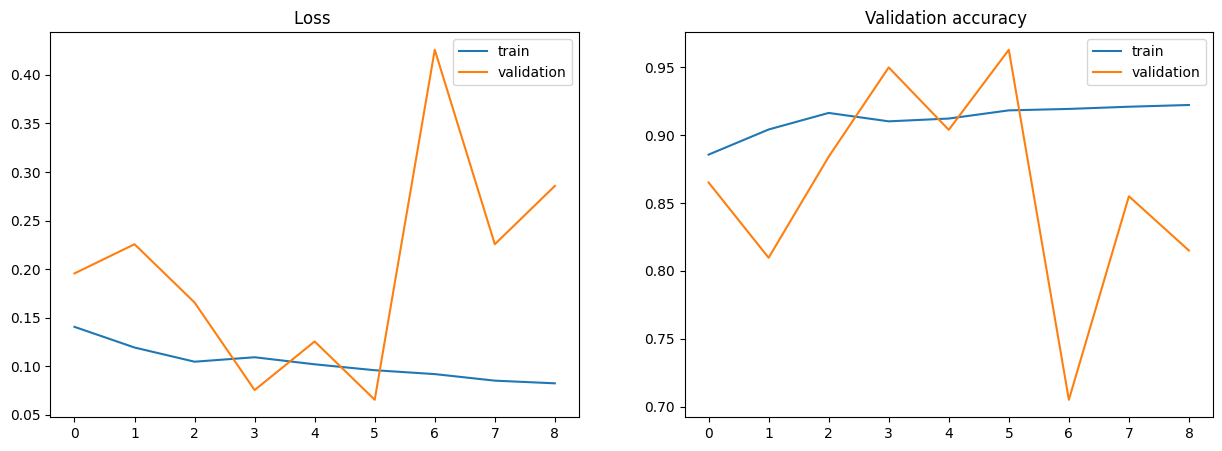

Epoch: 1
Средние train лосс и accuracy на последних 40 итерациях: 0.203165162820369 0.8054289321881345 
Средние train лосс и accuracy на последних 40 итерациях: 0.17810093123698606 0.8491789321881346 
Средние train лосс и accuracy на последних 40 итерациях: 0.15723322899236034 0.8677859547920898 
Средние train лосс и accuracy на последних 40 итерациях: 0.1436877777276095 0.8777680826175841 
Средние train лосс и accuracy на последних 40 итерациях: 0.14055408536922187 0.8857144660940673 
Эпоха 1/10: val лосс и accuracy: 0.1955597573891282 0.8651715728752538 
Epoch: 2
Средние train лосс и accuracy на последних 40 итерациях: 0.132215227423391 0.8901787217450561 
Средние train лосс и accuracy на последних 40 итерациях: 0.12447284766406352 0.8923879612503626 
Средние train лосс и accuracy на последних 40 итерациях: 0.12335294061340392 0.8976118326175839 
Средние train лосс и accuracy на последних 40 итерациях: 0.12525462789926678 0.8995676807816377 
Средние train лосс и accuracy на последних

In [47]:
n_epoch = 10
model.train(train_gen.random_g, val_gen.random_g, n_epoch)
model.save('best')

In [ ]:
#LBL3
epoch = 5
model.load(f'Epoch {epoch.bin}', test=False)

Пример пайплайна для тестирования обученной модели:

In [63]:
new_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale)
new_model.load()
sibatracc_final = new_model.test(Path('/kaggle/input/test/'), [1, 2], do_visualization=False, test_name='test')
print(f'SiBaTrAcc final value: {sibatracc_final}')

Downloading...
From: https://drive.google.com/uc?id=1_pScJOR5a4Ue1f0H-vJ8E6f-ZgdEzWOl
To: /kaggle/working/best.npz
100%|██████████| 888k/888k [00:00<00:00, 129MB/s]


loading clip data (game 1, clip 1) downscaled
loading clip labels (game 1, clip 1)
doing predictions


/tmp/ipykernel_102/2714528052.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(dec3.permute(0, 2, 3, 1).flatten(1, 2))


predictions are made
0.7527347875351885
loading clip data (game 1, clip 2) downscaled
loading clip labels (game 1, clip 2)
doing predictions
predictions are made
0.8234604479904599
loading clip data (game 1, clip 3) downscaled
loading clip labels (game 1, clip 3)
doing predictions
predictions are made
0.6833333333333333
loading clip data (game 1, clip 4) downscaled
loading clip labels (game 1, clip 4)
doing predictions
predictions are made
0.7288888888888889
loading clip data (game 1, clip 5) downscaled
loading clip labels (game 1, clip 5)
doing predictions
predictions are made
0.7318077274237283
loading clip data (game 1, clip 6) downscaled
loading clip labels (game 1, clip 6)
doing predictions
predictions are made
0.7889968390203321
loading clip data (game 1, clip 7) downscaled
loading clip labels (game 1, clip 7)
doing predictions
predictions are made
0.635978835978836
loading clip data (game 1, clip 8) downscaled
loading clip labels (game 1, clip 8)
doing predictions
predictions ar

In [ ]:
output_path

Во время самостоятельного тестирования попробуйте хотя бы раз сделать тестирование с визуализацией (do_visualization=True), чтобы визуально оценить качество трекинга разработанной моделью.

<font color=red>
Загрузка модели через функцию load должна происходить полностью автоматически без каких-либо действий со стороны пользователя! Один из вариантов подобной реализации с использованием google drive и пакета gdown приведен в разделе с дополнениями.
</font>

## Дополнения

Иногда при записи большого количества файлов в output директорию kaggle может "тупить" и не отображать корректно структуру дерева файлов в output и не показывать кнопки для скачивания выбранного файла. В этом случае удобно будет запаковать директорию с экспериментом и выкачать ее вручную. Пример для выкачивания директории с первым экспериментом приведен ниже:

In [ ]:
%cd /kaggle/working/
# !zip -r "exp_6.zip" "exp_6"
from IPython.display import FileLink
# FileLink(r'exp_6.zip')
FileLink(r'exp_1/best.txt')

удалить лишние директории или файлы в output тоже легко:

In [ ]:
!rm -r /kaggle/working/exp_2

Для реализации загрузки данных рекомендуется использовать облачное хранилище google drive и пакет gdown для скачивания файлов. Пример подобного использования приведен ниже:
1. загружаем файл в google drive (в данном случае, это npz архив, содержащий один numpy массив по ключу 'w')
2. в интерфейсе google drive открываем доступ на чтение к файлу по ссылке и извлекаем из ссылки id файла
3. формируем url для скачивания файла
4. с помощью gdown скачиваем файл
5. распаковываем npz архив и пользуемся numpy массивом

<font color="red">
Обратите внимание, что для корректной работы нужно правильно определить id файла. В частности, в ссылке https://drive.google.com/file/d/1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA/view?usp=sharing id файла заключен между ...d/ b /view?... и равен 1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA
</font>

In [ ]:
import gdown

id = '1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA'
url = f'https://drive.google.com/uc?id={id}'
output = 'sample-weights.npz'
gdown.download(url, output, quiet=False)

import numpy as np

weights = np.load('/kaggle/working/sample-weights.npz')['w']
print(weights)